<a href="https://colab.research.google.com/github/otanet/NLP_seminar_20201022/blob/main/AllenNLP%E3%81%AB%E3%82%88%E3%82%8B%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86_(1)_bag_of_embeddings%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AB%E3%82%88%E3%82%8B%E6%96%87%E6%9B%B8%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AllenNLPによる自然言語処理 (1): bag-of-embeddingsモデルによる文書分類

**他のノートブックへのリンク：**

* [AllenNLPによる自然言語処理 (2): 畳み込みニューラルネットワークによる感情分析](https://colab.research.google.com/drive/1v0YHDTFbQYixdxWf-pp1pZRZ4nkcsy2b?usp=sharing)
* [AllenNLPによる自然言語処理 (3): BERTによる固有表現認識](https://colab.research.google.com/drive/13ga1yYYZkosGZy9ZinAB76blb-8k6yby?usp=sharing)

このノートブックでは、ディープラーニングを用いた自然言語処理のためのツールである[AllenNLP](https://allennlp.org/)を用いて、文書分類のシステムを作成します。

AllenNLPは、[Allen Institute for Artificial Intelligence](https://allenai.org/)という米国の研究機関が開発を行っているオープンソースのツールです。
このツールは、ニューラルネットワークを用いた自然言語処理のモデルを効率的に開発することに特化して設計されていて、高度なニューラルネットワークのモデルを必要最低限の記述で実装できます。

AllenNLPは、モデルの実装を行う方法として、下記の2つの方法が提供しています。

* **Pythonを使う方法**: AllenNLPをライブラリとして用いて、必要な処理をPythonで記述する
* **設定ファイルを書く方法**：[Jsonnet](https://jsonnet.org/)形式で設定ファイルを書くことでシステムを開発する

このノートブックでは、まず[Livedoorニュースコーパス](https://www.rondhuit.com/download.html)を用いた文書分類システムをPythonで実装しながら、AllenNLPを使うにあたって理解する必要のある重要なコンポーネントの解説を行います。
次にPythonで作成したシステムと同様のものを設定ファイルで作成する方法を説明します。

## 環境のセットアップ

本ノートブックの実行に必要なパッケージをインストールします。

In [ ]:
# MeCabをインストール
!apt-get -qq install mecab swig libmecab-dev mecab-ipadic-utf8
# MeCabのPythonバインディングとAllenNLPをインストール
# （boto3はAllenNLPの依存ライブラリだが、最新バージョンだとエラーになるためバージョンを指定）
!pip install "mecab-python3==0.996.5" "allennlp==1.1.0" "boto3==1.15.0"

Selecting previously unselected package libmecab2:amd64.
(Reading database ... 144611 files and directories currently installed.)
Preparing to unpack .../0-libmecab2_0.996-5_amd64.deb ...
Unpacking libmecab2:amd64 (0.996-5) ...
Selecting previously unselected package libmecab-dev.
Preparing to unpack .../1-libmecab-dev_0.996-5_amd64.deb ...
Unpacking libmecab-dev (0.996-5) ...
Selecting previously unselected package mecab-utils.
Preparing to unpack .../2-mecab-utils_0.996-5_amd64.deb ...
Unpacking mecab-utils (0.996-5) ...
Selecting previously unselected package mecab-jumandic-utf8.
Preparing to unpack .../3-mecab-jumandic-utf8_7.0-20130310-4_all.deb ...
Unpacking mecab-jumandic-utf8 (7.0-20130310-4) ...
Selecting previously unselected package mecab-jumandic.
Preparing to unpack .../4-mecab-jumandic_7.0-20130310-4_all.deb ...
Unpacking mecab-jumandic (7.0-20130310-4) ...
Selecting previously unselected package mecab-ipadic.
Preparing to unpack .../5-mecab-ipadic_2.7.0-20070801+main-1_a

## データセットのセットアップ

本ノートブックでは、データセットとして[Livedoorニュースコーパス](https://www.rondhuit.com/download.html)を用います。このデータセットは、LivedoorニュースというWebニュースサイトから収集されたニュース記事に対して9種類のラベルが付与された日本語のデータセットです。 ラベルは、それぞれニュース記事を取得したサービスの名称に対応しています。

Livedoorニュースで使われている9種類のラベルと対応するサービス名称：

| ラベル | サービス名称 |
| --- | --- |
| dokujo-tsushin | 独女通信 |
| it-life-hack | ITライフハック |
| kaden-channel | 家電チャンネル |
| livedoor-homme | livedoor HOMME |
| movie-enter | MOVIE ENTER |
| peachy | Peachy |
| smax | エスマックス |
| sports-watch | Sports Watch |
| topic-news | トピックニュース |

### データセットのダウンロード

データセットをダウンロードして展開します。下記のコマンドによって、`data/livedoor_news/text`にデータセットが出力されます。

In [ ]:
# データセットの出力ディレクトリを作成
!mkdir -p data/livedoor_news
# データセットをダウンロード
!wget -q -O data/livedoor_news/ldcc-20140209.tar.gz https://www.rondhuit.com/download/ldcc-20140209.tar.gz
# データセットを解凍し、data/livedoor_newsに展開
!tar xzf data/livedoor_news/ldcc-20140209.tar.gz -C data/livedoor_news

`data/livedoor_news/text`には、ラベルと同一のディレクトリ名に記事が格納されます。

In [ ]:
# data/livedoor_news.text以下のディレクトリを列挙
!cd data/livedoor_news/text; ls -d */

dokujo-tsushin/  kaden-channel/   movie-enter/	smax/	       topic-news/
it-life-hack/	 livedoor-homme/  peachy/	sports-watch/


### データセットを行区切りJSON形式に変換

データセットをAllenNLPの`TextClassificationJsonReader`で読み込める[行区切りJSON（JSON lines）](https://jsonlines.org/)形式に変換します。
このスクリプトはデータセットを読み込んで8:1:1の割合でそれぞれ訓練用、検証用、テスト用に分割し、保存します。

In [ ]:
import glob
import json
import os
import random

import torch

# ラベルとして用いられる9個のカテゴリ
labels = ["dokujo-tsushin", "it-life-hack", "kaden-channel", "livedoor-homme",
          "movie-enter", "peachy", "smax", "sports-watch", "topic-news"]
data = []

# データセットをファイルから読み込む
for label in labels:
    dir_path = os.path.join("data/livedoor_news/text", label)
    for file_path in sorted(glob.glob(os.path.join(dir_path, "*.txt"))):
        with open(file_path) as f:
            text = f.read()
            # メタデータを削除し、記事部分のみを用いる
            text = "".join(text.split("\n")[2:])
        data.append(dict(text=text, label=label))

# データセットをランダムに並べ替える
random.seed(1)
random.shuffle(data)

# データセットの80%を訓練データ、10%を検証データ、10%をテストデータとして用いる
split_data = {}
eval_size = int(len(data) * 0.1)
split_data["test"] = data[:eval_size]
split_data["validation"] = data[eval_size:eval_size * 2]
split_data["train"] = data[eval_size * 2:]

# 行区切りJSON形式でデータセットを書き込む
for fold in ("train", "validation", "test"):
    out_file = os.path.join("data/livedoor_news", "livedoor_news_{}.jsonl".format(fold))
    with open(out_file, mode="w") as f:
        for item in split_data[fold]:
            json.dump(item, f, ensure_ascii=False)
            f.write("\n")

3個のファイルが`data/livedoor_news`に生成されます。

* **訓練用のデータ**: `livedoor_news_train.jsonl`
* **検証用のデータ**: `livedoor_news_validation.jsonl`
* **テスト用のデータ**: `livedoor_news_test.jsonl`

In [ ]:
!ls data/livedoor_news/*.jsonl

data/livedoor_news/livedoor_news_test.jsonl
data/livedoor_news/livedoor_news_train.jsonl
data/livedoor_news/livedoor_news_validation.jsonl


## Pythonを用いた文書分類システムの開発

AllenNLPをPythonライブラリとして用いて、文書分類システムを開発します。また、AllenNLPを使う上で理解する必要のあるコンポーネントについて、実際にPythonのコードで動かしながら解説します。

### データセットの読み込み

データセットを読み込んで、モデルに入力するデータを作成する処理を実装します。

#### トークナイザの作成

AllenNLPを用いてテキストを扱うには、テキストを単語や文字などの細かい単位に分割する必要があります。
この処理を行うのが**トークナイザ**です。

テキストの単語分割の例：

![[テキストの単語分割]](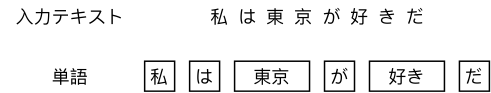)

日本語の単語分割を行う標準的なツールである[MeCab](https://taku910.github.io/mecab/](https://taku910.github.io/mecab/)を用いたトークナイザを記述します。

AllenNLPで新しい単語分割の機能を実装するには`allennlp.data.tokenizers.tokenizer.Tokenizer`の子クラスとして新しいクラスを定義し、`tokenize`メソッドの中に単語分割を行うコードを記述します。
また、`@Tokenizer.register("mecab")`とクラスにデコレータを付与することで実装したトークナイザを`mecab`という名前でAllenNLPに登録します。

In [ ]:
import MeCab
from allennlp.data.tokenizers.token import Token
from allennlp.data.tokenizers.tokenizer import Tokenizer

@Tokenizer.register("mecab")
class MecabTokenizer(Tokenizer):
    def __init__(self):
        # MeCabのインスタンスを作成
        self._mecab = MeCab.Tagger()

    def tokenize(self, text):
        """入力テキストをMeCabを用いて解析する"""

        # 入力テキストをMeCabで処理
        node = self._mecab.parseToNode(text)
        tokens = []
        cur = 0
        # 分割結果を順に参照し、tokensに格納
        while node:
            word = str(node.surface)
            space_length = node.rlength - node.length
            idx = cur + space_length
            cur += len(word) + space_length

            # MeCabの返す単語の特徴文字列から品詞を抜き出す
            # （例: 名詞,代名詞,一般,*,*,*,私,ワタシ,ワタシ）
            pos = node.feature.split(",")[0]

            # 文頭ノード（BOS）、文末ノード（EOS）は無視する
            if node.stat not in (MeCab.MECAB_BOS_NODE, MeCab.MECAB_EOS_NODE):
                tokens.append(Token(text=word, idx=idx, pos_=pos))

            # 次のノードを取り出す
            node = node.next

        return tokens

実装したトークナイザの動作を確認してみましょう。

In [ ]:
tokenizer = MecabTokenizer()
tokens = tokenizer.tokenize("私は東京が好きだ")
tokens

[私, は, 東京, が, 好き, だ]

#### データセットリーダの作成

**データセットリーダ**は、データセットの読み込みを行うためのコンポーネントです。

上で作成した行区切りJSONデータを文書分類のデータセット向けのデータセットリーダである`TextClassificationJsonReader`を用いて読み込みます。

ここで、`TextClassificationJsonReader `の`tokenizer`引数に、先ほど実装した`MecabTokenizer`を指定します。
また、次節で解説する**トークンインデクサ**として、`SingleIdTokenIndexer`を指定します。

In [ ]:
from allennlp.data.dataset_readers import TextClassificationJsonReader
from allennlp.data.token_indexers import SingleIdTokenIndexer
token_indexer = SingleIdTokenIndexer()
reader = TextClassificationJsonReader(tokenizer=tokenizer,
                                      token_indexers=dict(tokens=token_indexer))
train_dataset = reader.read('data/livedoor_news/livedoor_news_train.jsonl')
validation_dataset = reader.read("data/livedoor_news/livedoor_news_validation.jsonl")

reading instances: 5902it [00:19, 303.20it/s]
reading instances: 737it [00:03, 242.54it/s]


データセットリーダは、`AllennlpDataset`のインスタンスを出力します。

In [ ]:
type(train_dataset)

allennlp.data.dataset_readers.dataset_reader.AllennlpDataset

`AllennlpDataset`クラスは、データセット中に含まれる複数の**インスタンス**（`allennlp.data.instance.Instance`）を含むコンテナクラスです。インデックスを指定することで配列と同様にインスタンスを取り出すことができます。


In [ ]:
instance = train_dataset[0]
type(instance)

allennlp.data.instance.Instance

各インスタンスは1つ以上の**フィールド**（`allennlp.data.fields.field.Field`）を持ちます。

`TextClassificationJsonReader`の出力するインスタンスは、文書の単語列を含む`tokens`フィールドとラベルを含む`label`フィールドの2つのフィールドを持ちます。

In [ ]:
instance.fields

{'label': <allennlp.data.fields.label_field.LabelField at 0x7f72091be7e0>,
 'tokens': <allennlp.data.fields.text_field.TextField at 0x7f71bec4e7c8>}

In [ ]:
instance.fields["tokens"][:20]

[【, オトナ, 女子, 映画, 部, 】, あの, 時, こう, し, て, いれ, ば, …, “, 優柔不断, 女子, ”, に, 贈る]

In [ ]:
instance.fields["label"].label

'dokujo-tsushin'

#### 語彙とトークンインデクサ

AllenNLPでは、データセットに含まれる文字列などの値は整数値のIDに変換してからモデルに入力します。
AllenNLPでは、**語彙**と**トークンインデクサ**がこの処理を担います。

* **語彙**: データセット中に含まれる値に対して固有のIDを結びつける、値からIDへのマッピングを保持した辞書
* **トークンインデクサ**： 入力テキストに含まれる各単語にIDを付与するためのコンポーネント

##### 語彙の作成

語彙の作成は`Vocabulary`クラスの`from_instances`メソッドを用いてデータセットから直接行います。
`from_instances`メソッドは、データセットに含まれる値を参照して異なる値を列挙し、それぞれの値に対してIDを結びつけて語彙を生成します。

In [ ]:
from allennlp.data.vocabulary import Vocabulary
vocab = Vocabulary.from_instances(train_dataset + validation_dataset)

building vocab: 100%|##########| 6639/6639 [00:02<00:00, 2249.17it/s]


生成された語彙（`vocab`）には、`tokens`フィールドと`label`フィールドに対応した2つの異なる語彙が含まれており、それぞれ`tokens`と`labels`の2つのネームスペースに格納されます。

`Vocabulary`クラスの`get_token_index`メソッドを用いて、語彙が正しく生成されているか確認します。 このメソッドは`namespace`引数にネームスペースを指定することで参照する語彙を選択できます。

In [ ]:
vocab.get_token_index("東京", namespace="tokens")

249

In [ ]:
vocab.get_token_index("dokujo-tsushin", namespace="labels")

4

`tokens`フィールドに対応する語彙では、単語「東京」に249、`label`フィールドに対応する語彙では、ラベル名「dokujo-tsushin」に4のIDが割り当てられたことが分かります。

次に`AllennlpDataset`の`index_with`メソッドを用いて、データセットを処理する際に作成した語彙を使うように設定します。

In [ ]:
train_dataset.index_with(vocab)
validation_dataset.index_with(vocab)

##### トークンインデクサの作成

トークンインデクサは、入力テキストに含まれる単語列にIDを付与します。

データセットリーダを作成する際に、下記のようにトークンインデクサを作成しました。

```python
token_indexer = SingleIdTokenIndexer()
```

`SingleIdTokenIndexer`は、語彙を参照して、単語列に含まれる各単語を該当するIDに変換するトークンインデクサです。
このクラスの`tokens_to_indices`メソッドを用いて、単語列をID列に変換します。
引数として、単語列（`tokens`）と語彙（`vocab`）を指定します。

In [ ]:
token_ids = token_indexer.tokens_to_indices(tokens, vocab)["tokens"]
token_ids

[140, 8, 249, 7, 224, 28]

作成した単語のID列（`token_ids`）を`Vocabulary`の`get_token_from_index`メソッドで変換前の単語に戻して確認してみます。

In [ ]:
[vocab.get_token_from_index(token_id) for token_id in token_ids]

['私', 'は', '東京', 'が', '好き', 'だ']

#### データローダの作成

モデルにデータセットを入力する際には、データセットに含まれるインスタンスを**ミニバッチ**と呼ばれる単位にまとめてから入力します。
一般的にミニバッチには一般に10〜100個程度のインスタンスが含まれます。

**データローダ**は、データセットに含まれるインスタンスを指定したサイズにまとめてミニバッチを出力するコンポーネントです。

読み込んだデータセット（`train_dataset`、`validation_dataset`）を使ってデータローダを作成します。
1つのミニバッチに含まれるインスタンス数（`batch_size`）には32を指定します。

訓練用データセットのデータローダのみ`shuffle=True`とすることでデータセット中のインスタンスをランダムに並び替えてからミニバッチを作成するように設定します。

In [ ]:
from allennlp.data import PyTorchDataLoader
train_loader = PyTorchDataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = PyTorchDataLoader(validation_dataset, batch_size=32, shuffle=False)

データローダからミニバッチを取り出してみましょう。
AllenNLPは、ミニバッチは`dict`型のオブジェクトです。


In [ ]:
batch = next(iter(validation_loader))
type(batch)

dict

ミニバッチには`tokens`および`label`の各フィールドに対応するID化されたデータが格納されています。

In [ ]:
batch.keys()

dict_keys(['tokens', 'label'])

`batch["tokens"]`には、行がインスタンスで列が単語のIDに対応する行列が値として含まれています。

In [ ]:
batch["tokens"]

{'tokens': {'tokens': tensor([[ 116,    8, 5788,  ...,    0,    0,    0],
          [ 232,  331,  374,  ...,    0,    0,    0],
          [ 460, 1458,    3,  ...,    0,    0,    0],
          ...,
          [ 327,    7,  170,  ...,    0,    0,    0],
          [2082, 1690,  668,  ...,    0,    0,    0],
          [1476,   60,    3,  ...,    0,    0,    0]])}}

`batch["label"]`はラベルのID列を含んでいます。

In [ ]:
batch["label"]

tensor([3, 4, 1, 4, 0, 8, 4, 3, 5, 3, 5, 3, 8, 2, 7, 3, 6, 5, 8, 6, 0, 8, 3, 5,
        5, 2, 4, 4, 0, 5, 2, 6])

`Vocabulary`クラスの`get_token_from_index`メソッドを使って、`batch`に含まれるIDから元の値を復元してみます。


In [ ]:
[vocab.get_token_from_index(int(i), namespace="tokens") for i in batch["tokens"]["tokens"]["tokens"][0]][:10]

['これ', 'は', '気づか', 'なかっ', 'た', '！', '古い', 'ノート', 'PC', 'が']

In [ ]:
vocab.get_token_from_index(int(batch["label"][0]), namespace="labels")

'it-life-hack'

### モデルの作成

文書分類のモデルを作成します。

#### bag-of-embeddingsモデル

文書分類において単純かつよく使われているモデルの1つに**bag-of-embeddingsモデル**があります。
下記に「新しい冷蔵庫がほしい」という文にこのモデルを適用した例を示します。

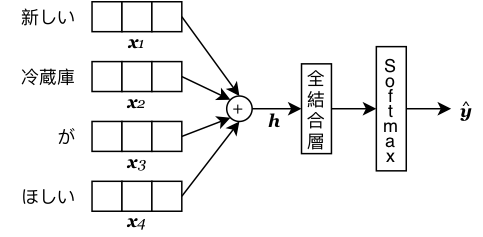

このモデルは以下の3つのステップで構成されます。

**1. 単語エンベディングの作成**

語彙中に含まれる全ての単語に対して1つの**単語エンベディング**（単語に対応するベクトル）を割り当てます。

**2. テキストの特徴ベクトルの作成**

分類対象の文書の特徴を含んだベクトル（特徴ベクトル）を、文書に含まれるすべての単語の単語エンベディングをベクトルの各次元単位で加算した値として計算します。
この例では、テキストはニュース記事に対応します。

**3. テキストの分類**

テキストの特徴ベクトルを全結合層に入力し、**ソフトマックス関数**を適用してテキストの分類を行います。
損失関数には**クロスエントロピー誤差関数**を用います。

#### 乱数シードの指定

ニューラルネットワークのモデルに含まれるパラメータは、乱数を用いて初期化されます。
乱数にシードを指定しておくと、乱数生成器から同じ乱数の系列が生成されるため、何度実行しても同じ値でパラメータの初期化が行われ、同じ訓練結果が得られます。

ここではPythonの`random`パッケージとPyTorchの双方にシードを設定します。

In [ ]:
import torch

random.seed(2)
torch.manual_seed(2)

#### 単語エンベディングの作成

語彙に含まれる全ての単語に対して、100次元の単語エンベディングを作成します。

単語エンベディングの作成は`Embedding`クラスを用いて行います。

このクラスのコンストラクタは、引数として単語エンベディングの数（`num_embeddings`）と単語エンベディングの次元数（`embedding_dim`）を取ります。
単語エンベディングの数は語彙に含まれる単語数と同じであるため、語彙に含まれる単語数を`Vocabulary`クラスの`get_vocab_size`メソッドを用いて取得します。


In [ ]:
from allennlp.modules.token_embedders import Embedding
embedding = Embedding(num_embeddings=vocab.get_vocab_size(), embedding_dim=100)

`Embedding`クラスは、単語や文字などのトークンを該当するエンベディングに変換して出力する**トークンエンベダ**の実装の1つになっていて`allennlp.modules.token_embedders`パッケージの中で定義されています。

AllenNLPではIDをエンベディングに変換する処理はトークンエンベダとして抽象化されていて、`Embedding`クラスは各IDに対して該当する単語エンベディングを出力する最も単純なトークンエンベダの実装になっています。

作成される単語エンベディングは$\mbox{語彙に含まれる単語数 (72,537)}\times\mbox{単語エンベディングの次元数 (100)}$の行列です。
この行列の行番号は単語のIDに対応していて、各単語のエンベディングはこの行列のID行目に格納されます。

In [ ]:
embedding.weight.size()

torch.Size([72537, 100])

`Embedding`のインスタンスは、単語のIDを示すテンソルを渡すと該当する単語エンベディングを返します。

In [ ]:
embedding(torch.tensor(1))

tensor([-3.3212e-03, -1.4645e-03, -8.7923e-03,  3.8381e-03,  5.1560e-03,
         2.8805e-03,  5.7754e-03,  6.8276e-03, -8.9720e-03,  1.3729e-03,
         8.4307e-03, -6.5867e-03, -4.0467e-03, -4.7862e-04, -5.6539e-03,
        -1.7130e-03, -1.3430e-03,  8.0977e-03, -5.7148e-04,  4.9285e-03,
         6.6554e-03,  4.0492e-03, -7.9038e-03,  6.8119e-03,  5.9935e-03,
        -6.5153e-03, -3.2407e-03,  6.1860e-03, -8.8351e-03, -7.9658e-03,
        -6.1599e-03,  2.8320e-03, -3.7115e-03, -8.1056e-03,  3.5230e-03,
         4.5972e-03,  3.4042e-03, -7.7869e-03,  8.8497e-03, -6.8574e-04,
        -8.6503e-03, -1.3682e-03,  5.9363e-03,  4.1856e-03, -9.7132e-05,
         6.4071e-03, -8.2922e-03,  6.3061e-03,  9.0218e-03, -5.5265e-03,
         1.9495e-03, -1.4656e-03, -7.6725e-03, -7.9678e-05, -3.0458e-03,
        -7.7630e-03, -6.6226e-03,  1.9831e-04,  8.4257e-03,  3.2540e-03,
        -6.0470e-03,  6.2688e-03,  7.4603e-04, -8.8809e-03,  4.3112e-04,
         5.8343e-03, -5.3441e-03, -4.1818e-04, -4.5

`BasicTextFieldEmbedder`は、トークンインデクサとトークンエンベダをつなげて用いるための**テキストフィールドエンベダ**のクラスです。
このクラスは、トークンインデクサが出力する単語ID列をトークンエンベダを用いてエンベディングの列に変換して出力します。

`BasicTextFieldEmbedder`のインスタンスは、トークンインデクサの名前（`tokens`）をキー、トークンエンベダを値とした`dict`を引数として作成します。


In [ ]:
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
text_embedder = BasicTextFieldEmbedder({"tokens": embedding})

作成したインスタンスにミニバッチに含まれる単語のID列を入力してみましょう。

In [ ]:
token_vectors = text_embedder(batch["tokens"])
token_vectors.size()

torch.Size([32, 6006, 100])

ミニバッチに含まれるインスタンスごとに、含まれる単語のIDが単語エンベディングに変換され、$\mbox{ミニバッチのサイズ（32）}\times\mbox{単語列の長さ（6,006）}\times\mbox{単語エンベディングの次元（100）}$で構成されるテンソルが出力されました。


#### テキストの特徴ベクトルの作成

次に単語エンベディングの列から、テキストの特徴ベクトルを計算する処理を実装します。

`BagOfEmbeddingsEncoder`はbag-of-embeddingsモデルを実装したクラスで、エンベディングの列を受け取ってそれらを全て要素単位で加算することで1つのベクトルを出力します。
このクラスは、単語エンベディングの次元数（`embedding_dim`）を受け取ります。

In [ ]:
from allennlp.modules.seq2vec_encoders import BagOfEmbeddingsEncoder
encoder = BagOfEmbeddingsEncoder(embedding_dim=100)

`BagOfEmbeddingsEncoder`はエンベディングの列（sequence）を受け取って、それをベクトル（vector）に変換する**seq2vecエンコーダ**の実装の1つになっていて、`allennlp.modules.seq2vec_encoders`パッケージの中に定義されています。
seq2vecエンコーダには`BagOfEmbeddingsEncoder`の他にも畳み込みニューラルネットワーク等のベクトルの列を1つのベクトルに変換する実装が含まれています。

前節で計算した単語エンベディング列（`token_vectors`）を入力してみましょう。

In [ ]:
text_vector = encoder(token_vectors)
text_vector.size()

torch.Size([32, 100])

単語エンベディング列が加算されて、$\mbox{ミニバッチのサイズ（32）}\times\mbox{単語エンベディングの次元（100）}$のテンソルが出力されました。

#### 文書分類器の作成

文書の分類を行うモデルの実装は`BasicClassifier`を用いて行います。
`BasicClassifier`は、まず指定したテキストフィールドエンベダとsec2vecエンコーダを用いて入力テキストのベクトルを計算します。
そして全結合層にこのベクトルを入力して、最後にソフトマックス関数を適用することで、分類を行います。

`BasicClassifier`は、引数として語彙（`vocab`）、テキストフィールドエンベダ（`text_field_embedder`）、seq2vecエンコーダ（`seq2vec_encoder`）を取ります。

In [ ]:
from allennlp.models import BasicClassifier
model = BasicClassifier(vocab=vocab, text_field_embedder=text_embedder,
                        seq2vec_encoder=encoder)

モデルの`cuda`メソッドを呼ぶことで、GPU上にモデルをコピーします。

In [ ]:
model = model.cuda()

データローダは既に上で作成しましたが、データローダが乱数を使用する影響で、このモデルが後述する設定ファイルによるモデルと同様の訓練結果になるようにするためには、モデルの定義の後にデータローダの作成を行う必要があります。
そこで、データローダを再度作成しなおします。

設定ファイルと同様の訓練結果にする必要がない場合は、こちらを実行する必要はありません。

In [ ]:
train_loader = PyTorchDataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = PyTorchDataLoader(validation_dataset, batch_size=32, shuffle=False)

### モデルの訓練

作成した文書分類モデルを訓練します。

#### オプティマイザの作成

**オプティマイザ**を作成します。
オプティマイザは、訓練時に損失を最小化するようにモデルに含まれるパラメータを更新するコンポーネントです。
ここでは標準的に使われているオプティマイザである**Adam**を実装した**Adamオプティマイザ**（`AdamOptimizer`）を用います。

モデルの`named_parameters`メソッドを呼ぶことで、モデルに含まれる全てのパラメータのリストを名前付きで取得できます。
このメソッドを用いて取得したパラメータのリストをオプティマイザに渡します。

In [ ]:
from allennlp.training.optimizers import AdamOptimizer
optimizer = AdamOptimizer(model.named_parameters())

#### トレイナの作成

モデルの訓練を実行するクラスである**最急降下法トレイナ**（`GradientDescentTrainer`）をモデル（`model`）、オプティマイザ（`optimizer`）、データローダ（`data_loader`）、訓練データセット（`train_dataset`）、検証データセット（`validation_dataset`）を渡して作成します。

`num_epochs=10`と指定することで訓練用のデータセットを最大で10回イテレーションして学習するように指定します。
ここで**エポック**（**epoch**）は訓練データセットを1回イテレーションすることをあらわします。
また`patience=3`と指定することで、各エポック終了時に検証用のデータセットで損失を計算し、損失が連続して3エポック下がっていなかった場合に訓練を終了します。


In [ ]:
from allennlp.training import GradientDescentTrainer
trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=train_loader,
    validation_data_loader=validation_loader,
    num_epochs=10,
    patience=3,
    cuda_device=0
)

#### 訓練の実行

トレイナの`train`メソッドを呼んで訓練を実行します。

In [ ]:
metrics = trainer.train()

accuracy: 0.8929, batch_loss: 0.5190, loss: 0.3974 ||: 100%|##########| 185/185 [00:04<00:00, 39.00it/s]
accuracy: 0.9430, batch_loss: 0.1202, loss: 0.2169 ||: 100%|##########| 24/24 [00:00<00:00, 48.67it/s]
accuracy: 0.9963, batch_loss: 0.0142, loss: 0.0216 ||: 100%|##########| 185/185 [00:01<00:00, 169.32it/s]
accuracy: 0.9525, batch_loss: 0.0066, loss: 0.2149 ||: 100%|##########| 24/24 [00:00<00:00, 268.01it/s]
accuracy: 0.9981, batch_loss: 0.0036, loss: 0.0145 ||: 100%|##########| 185/185 [00:01<00:00, 175.34it/s]
accuracy: 0.9579, batch_loss: 0.0039, loss: 0.1724 ||: 100%|##########| 24/24 [00:00<00:00, 303.80it/s]
accuracy: 0.9995, batch_loss: 0.0021, loss: 0.0047 ||: 100%|##########| 185/185 [00:01<00:00, 179.05it/s]
accuracy: 0.9593, batch_loss: 0.0029, loss: 0.1703 ||: 100%|##########| 24/24 [00:00<00:00, 303.84it/s]
accuracy: 0.9995, batch_loss: 0.0035, loss: 0.0036 ||: 100%|##########| 185/185 [00:01<00:00, 179.14it/s]
accuracy: 0.9579, batch_loss: 0.0018, loss: 0.1713 ||: 1

#### 指標の確認

トレイナが返した指標を表示します。

In [ ]:
import pprint
pprint.pprint(metrics)

{'best_epoch': 3,
 'best_validation_accuracy': 0.9592944369063772,
 'best_validation_loss': 0.17032085664686747,
 'epoch': 5,
 'peak_gpu_0_memory_MB': 1789,
 'peak_worker_0_memory_MB': 6068.672,
 'training_accuracy': 0.9996611318197222,
 'training_duration': '0:00:11.524001',
 'training_epochs': 5,
 'training_gpu_0_memory_MB': 1789,
 'training_loss': 0.0028502423625370184,
 'training_start_epoch': 0,
 'training_worker_0_memory_MB': 6068.672,
 'validation_accuracy': 0.9565807327001357,
 'validation_loss': 0.17460694712159844}


出力された指標を見ると、最も検証データセット上での性能が良かった4エポック（`"best_epoch": 3`）終了時のモデルが最終的なモデルとして選択されたことが分かります。
また、検証データセットでの最良の正解率（`best_validation_accuracy`）は約95.9%だったことがわかります。
なお、正解率は下記で定義されます。
$$\mbox{正解率} = \frac{\mbox{正解したインスタンス数}}{\mbox{全てのインスタンス数}}$$

## 設定ファイルを用いた文書分類システムの開発

上述したPythonによるモデルと同じモデルを[Jsonnet](https://jsonnet.org/)形式の設定ファイルで記述する方法を解説します。

### 設定ファイルの作成

設定ファイルには、下記の内容を含める必要があります。

* 入力するデータセットのパス
* データセットリーダの設定
* 語彙の設定
* データローダの設定
* モデルの設定
* トレイナの設定

まず設定ファイルを`livedoor_news.jsonnet`に書き込みます。

In [ ]:
model_config = """{
    "random_seed": 2,
    "pytorch_seed": 2,
    "train_data_path": "data/livedoor_news/livedoor_news_train.jsonl",
    "validation_data_path": "data/livedoor_news/livedoor_news_validation.jsonl",
    "dataset_reader": {
        "type": "text_classification_json",
        "tokenizer": {
            "type": "mecab"
        },
        "token_indexers": {
            "tokens": {
                "type": "single_id"
            }
        }
    },
    "vocabulary": {},
    "datasets_for_vocab_creation": ["train", "validation"],
    "data_loader": {
        "batch_size": 32,
        "shuffle": true
    },
    "validation_data_loader": {
        "batch_size": 32,
        "shuffle": false
    },
    "model": {
        "type": "basic_classifier",
        "text_field_embedder": {
            "token_embedders": {
                "tokens": {
                    "type": "embedding",
                    "embedding_dim": 100
                }
            }
        },
        "seq2vec_encoder": {
           "type": "bag_of_embeddings",
           "embedding_dim": 100
        }
    },
    "trainer": {
        "optimizer": {
            "type": "adam"
        },
        "num_epochs": 10,
        "patience": 3,
        "cuda_device": 0
    }
}"""
with open("livedoor_news.jsonnet", "w") as f:
  f.write(model_config)

#### 乱数シードの指定

乱数のシードを指定します。
```json
    "random_seed": 2,
    "pytorch_seed": 2,
```

#### データセットのパスの指定

訓練用のデータセットのパス（`train_data_path`）および検証用のデータセットのパス（`validation_data_path`）を指定します。

```json
    "train_data_path": "data/livedoor_news/livedoor_news_train.jsonl",
    "validation_data_path": "data/livedoor_news/livedoor_news_validation.jsonl",
```

#### データセットリーダの設定


データセットリーダを作成します。

AllenNLPの設定ファイルでクラスに関連する設定を記述する際は、クラスの名前を`type`属性で指定し、そのクラスへの引数をそのほかの属性で指定します。
ここでクラスの名前には該当するクラスのAllenNLP上での登録名を指定します。
AllenNLPに実装されているクラスの登録名は[ドキュメントに記載](https://docs.allennlp.org/v1.1.0/api/data/dataset_readers/text_classification_json/)されています。

ここではデータセットリーダとして`TextClassificationJsonReader`（`text_classification_json`）を指定し、このクラスへの引数としてトークナイザとトークンインデクサの設定を指定します。
トークナイザには`MecabTokenizer`（`mecab`）、トークンインデクサには`SingleIdTokenIndexer`（`single_id`）を指定します。

```json
    "dataset_reader": {
        "type": "text_classification_json",
        "tokenizer": {
            "type": "mecab"
        },
        "token_indexers": {
            "tokens": {
                "type": "single_id"
            }
        }
    },
```

#### 語彙の設定

語彙の設定を行います。

ここではPythonでの実装と同様に引数を指定せずに空の設定を記述します。
また`datasets_for_vocab_creation`属性で、語彙の作成の際に訓練データセット（`train`）と検証データセット（`validation`）の双方を用いるように設定します。

```json
    "vocabulary": {},
    "datasets_for_vocab_creation": ["train", "validation"],
```

#### データローダの設定

データローダを設定します。

訓練データセット用のデータローダ（`data_loader`）と検証データセット用のデータローダ（`validation_data_loader`）の2つのデータローダを作成します。
`batch_size`には32を指定します。訓練データセット用のデータローダのみ`shuffle`属性を`true`に指定し、データセット中のインスタンスをランダムに並び替えてからミニバッチを作成するように設定します。


```json
    "data_loader": {
        "batch_size": 32,
        "shuffle": true
    },
    "validation_data_loader": {
        "batch_size": 32,
        "shuffle": false
    },
```

#### モデルの設定

モデルの設定を行います。

`BasicClassifier`（`basic_classifier`）に対して、テキストフィールドエンベダ（`text_field_embedder`）とseq2vecエンコーダ（`seq2vec_encoder`）を引数として指定します。

テキストフィールドエンベダで用いるトークンエンベダとして`Embedding`（`embedding`）を指定し、seq2vecエンコーダには`BagOfEmbeddingsEncoder`（`bag_of_embeddings`）を指定します。指定する引数およびその値は、Pythonの実装で用いたものと同様のものを用います。

```json
    "model": {
        "type": "basic_classifier",
        "text_field_embedder": {
            "token_embedders": {
                "tokens": {
                    "type": "embedding",
                    "embedding_dim": 100
                }
            }
        },
        "seq2vec_encoder": {
           "type": "bag_of_embeddings",
           "embedding_dim": 100
        }
    },
```

#### トレイナの設定

トレイナの設定を行います。

指定する引数およびその値は、Pythonの実装で用いたものと同様のものを用います。

```json
    "trainer": {
        "optimizer": {
            "type": "adam"
        },
        "num_epochs": 10,
        "patience": 3,
        "cuda_device": 0
    }
```

### モデルの訓練

作成した設定ファイルを用いて、訓練を実行します。

まず、上述した`MecabTokenizer`をAllenNLPコマンドから参照可能にするために、同様の内容を記述した`mecab_tokenizer.py`をダウンロードします。

In [ ]:
!wget -q https://dl.dropboxusercontent.com/s/2qeulihmlv8btbg/mecab_tokenizer.py

モデルの訓練は、`allennlp train`コマンドを用いて行います。
**出力ディレクトリ**を`--serialization-dir`引数を用いて`exp_livedoor_news`ディレクトリに指定します。

In [ ]:
!rm -rf exp_livedoor_news
!allennlp train --serialization-dir exp_livedoor_news --include-package mecab_tokenizer livedoor_news.jsonnet

2020-10-20 05:24:15.555313: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-20 05:24:16,706 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
2020-10-20 05:24:17,438 - INFO - allennlp.common.params - random_seed = 2
2020-10-20 05:24:17,438 - INFO - allennlp.common.params - numpy_seed = 1337
2020-10-20 05:24:17,438 - INFO - allennlp.common.params - pytorch_seed = 2
2020-10-20 05:24:17,444 - INFO - allennlp.common.checks - Pytorch version: 1.6.0+cu101
2020-10-20 05:24:17,445 - INFO - allennlp.common.params - type = default
2020-10-20 05:24:17,446 - INFO - allennlp.common.params - dataset_reader.type = text_classification_json
2020-10-20 05:24:17,446 - INFO - allennlp.common.params - dataset_reader.lazy = False
2020-10-20 05:24:17,446 - INFO - allennlp.common.params - dataset_reader.cache_directory = None
2020-10-20 05:24:17,446 - INFO - allennlp.common.params - dataset_reader.max_instances 

Pythonで記述したモデルを訓練した際と同じ指標の値が出力されており、設定ファイルを用いてPythonで記述したモデルと同様のモデルを記述できたことが分かります。
```json
{
  "best_epoch": 3,
  "peak_worker_0_memory_MB": 5391.28,
  "peak_gpu_0_memory_MB": 3446,
  "training_duration": "0:00:13.445964",
  "training_start_epoch": 0,
  "training_epochs": 5,
  "epoch": 5,
  "training_accuracy": 0.9996611318197222,
  "training_loss": 0.0028502423625370184,
  "training_worker_0_memory_MB": 5391.28,
  "training_gpu_0_memory_MB": 3446,
  "validation_accuracy": 0.9565807327001357,
  "validation_loss": 0.17460694712159844,
  "best_validation_accuracy": 0.9592944369063772,
  "best_validation_loss": 0.17032085664686747
}
```

訓練が終わると、出力ディレクトリに`model.tar.gz`というファイルが生成されます。
このファイルは、モデルを動作させるのに必要なデータを1つのファイルにまとめた**アーカイブファイル**と呼ばれるファイルで、中身には語彙（`vocabulary`ディレクトリ）、実行した設定の内容を格納したJSONファイル（`config.json`）、訓練したモデルの重み（`weights.th`）が含まれます。


In [ ]:
!tar tf exp_livedoor_news/model.tar.gz

config.json
weights.th
vocabulary/
vocabulary/tokens.txt
vocabulary/.lock
vocabulary/non_padded_namespaces.txt
vocabulary/labels.txt


### 性能の評価

学習したモデルをテスト用のデータセットを使って評価してみましょう。
AllenNLPには評価を行うための`evaluate`コマンドが用意されています。
このコマンドでは、第1引数にモデルのアーカイブファイル、第2引数にテスト用データセットのパスを指定します。

In [ ]:
!allennlp evaluate --include-package mecab_tokenizer exp_livedoor_news/model.tar.gz data/livedoor_news/livedoor_news_test.jsonl

2020-10-20 05:25:09.929902: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-20 05:25:11,448 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
2020-10-20 05:25:12,442 - INFO - allennlp.models.archival - loading archive file exp_livedoor_news/model.tar.gz
2020-10-20 05:25:12,443 - INFO - allennlp.models.archival - extracting archive file exp_livedoor_news/model.tar.gz to temp dir /tmp/tmpn5nta8p1
2020-10-20 05:25:12,705 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpn5nta8p1/vocabulary.
2020-10-20 05:25:12,857 - INFO - allennlp.common.checks - Pytorch version: 1.6.0+cu101
2020-10-20 05:25:12,860 - INFO - allennlp.commands.evaluate - Reading evaluation data from data/livedoor_news/livedoor_news_test.jsonl
reading instances: 737it [00:02, 301.31it/s]
2020-10-20 05:25:15,308 - INFO - allennlp.training.util - Iterating over dataset
accuracy: 0.96, loss: 0.13 ||: : 24i

テスト用データセットでの正解率は約95.5%になりました。

### 学習したモデルを使う

学習したモデルを使ってテキストを分類してみましょう。まず分類する文書を`sentence`属性に含んだJSONファイル`text_classification_input.json`を用意します。

In [ ]:
!echo '{"sentence":"新しい冷蔵庫がほしい"}' > text_classification_input.json

AllenNLPでは学習したモデルを`predict`コマンドで実行することができます。
このコマンドでは、第1引数にモデルのアーカイブファイル、第2引数に入力ファイルのパスを指定します。

In [ ]:
!allennlp predict --include-package mecab_tokenizer exp_livedoor_news/model.tar.gz text_classification_input.json

2020-10-20 05:25:18.512825: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-20 05:25:19,780 - INFO - transformers.file_utils - TensorFlow version 2.3.0 available.
2020-10-20 05:25:20,560 - INFO - allennlp.models.archival - loading archive file exp_livedoor_news/model.tar.gz
2020-10-20 05:25:20,560 - INFO - allennlp.models.archival - extracting archive file exp_livedoor_news/model.tar.gz to temp dir /tmp/tmpz9541xyg
2020-10-20 05:25:20,816 - INFO - allennlp.common.params - vocabulary.type = from_instances
2020-10-20 05:25:20,816 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpz9541xyg/vocabulary.
2020-10-20 05:25:20,885 - INFO - allennlp.common.params - model.type = basic_classifier
2020-10-20 05:25:20,886 - INFO - allennlp.common.params - model.regularizer = None
2020-10-20 05:25:20,886 - INFO - allennlp.common.params - model.text_field_embedder.type = basic
2020-10-20 05:25:20,886 -

`prediction:`からはじまる行に各入力に対して予測された確率（`probs`）や予測結果（`label`）が表示されています。
下記に整形した結果を示します。
入力したテキストは、最も適したラベルと考えられる`kaden-channel`に正しく分類されていることが分かります。

```json
{
  "logits": [-0.10983803868293762, -0.1061975359916687, -0.15040323138237, 0.007181158289313316, 0.09041442722082138, 0.18144872784614563, 0.005449764430522919, 0.03223137557506561, -0.0071383314207196236],
  "probs": [0.09969189763069153, 0.10005548596382141, 0.095728799700737, 0.11206775158643723, 0.12179470807313919, 0.13340254127979279, 0.11187388747930527, 0.1149105355143547, 0.11047443002462387],
  "token_ids": [390, 4751, 7, 896],
  "label": "kaden-channel",
  "tokens": ["\u65b0\u3057\u3044", "\u51b7\u8535\u5eab", "\u304c", "\u307b\u3057\u3044"]
}
```

次に、`allennlp predict`と同様の処理を行うPythonコードを実装します。

Pythonから訓練したモデルのアーカイブファイルを読み込むには`load_archive`関数を使います。

In [ ]:
from allennlp.models.archival import load_archive
archive = load_archive("exp_livedoor_news/model.tar.gz")

AllenNLPで読み込んだモデルを使う場合は、**プレディクタ**を用います。

まず、`from_archive`メソッドを用いてアーカイブファイルからプレディクタのインスタンスを作成します。

In [ ]:
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_archive(archive)

プレディクタを使ってテキストを分類してみましょう。
`predict_json`メソッドに上述したJSONデータと同様の`dict`を渡します。

In [ ]:
predictor.predict_json({"sentence": "新しい冷蔵庫がほしい"})

{'label': 'kaden-channel',
 'logits': [-0.10983803868293762,
  -0.1061975359916687,
  -0.15040323138237,
  0.007181158289313316,
  0.09041442722082138,
  0.18144872784614563,
  0.005449764430522919,
  0.03223137557506561,
  -0.0071383314207196236],
 'probs': [0.09969189763069153,
  0.10005548596382141,
  0.095728799700737,
  0.11206775158643723,
  0.12179470807313919,
  0.13340254127979279,
  0.11187388747930527,
  0.1149105355143547,
  0.11047443002462387],
 'token_ids': [390, 4751, 7, 896],
 'tokens': ['新しい', '冷蔵庫', 'が', 'ほしい']}

前述した`predict`コマンドと同じ予測結果が得られました。

**他のノートブックへのリンク：**

* [AllenNLPによる自然言語処理 (2): 畳み込みニューラルネットワークによる感情分析](https://colab.research.google.com/drive/1v0YHDTFbQYixdxWf-pp1pZRZ4nkcsy2b?usp=sharing)
* [AllenNLPによる自然言語処理 (3): BERTによる固有表現認識](https://colab.research.google.com/drive/13ga1yYYZkosGZy9ZinAB76blb-8k6yby?usp=sharing)